# GRU model

We start by importing the necessary libraries

In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from core.util.plot_predictions import plot_predictions
from core.util.save_model import save_model
from core.util.get_datasets import get_test_set
from core.util.trefor_dataset import TreforData
from core.models import GRU
from core.models.model_training import blocked_training, test_model
from core.util.hyperparameter_configuration import get_hyperparameter_configuration
from core.util.metrics import mae, rmse, smape

## Setup
This section contains the setup for converting our data to something PyTorch can understand.
### Set hyperparameters for the model

In [2]:
# To be modified depending on gridsearch result
batch_size = 32
learning_rate = 0.001
num_layers = 1
lookback = 48

# Extract hyperparameters configuration that will not be tuned upon
(
    hidden_size,
    _,
    horizon,
    loss_function,
    dropout_rate,
    folds,
    early_stopper,
) = get_hyperparameter_configuration()

model_input_size = 1

### If the host has CUDA, it will use the GPU for computation

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

### Creation of our simple GRU model
The implementation consist of three layers, defined in the `forward` method.
1. GRU
2. LeakyReLU
3. Linear
4. ReLU

In [4]:
def get_model() -> nn.Module:
    """Get the model for training folds."""
    model = GRU(
        input_size=model_input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        horizon=horizon,
        lookback=lookback,
    )
    model.to(device)
    return model

## Main loop
Iterate all the cross validation folds to find the best one.

For each of these, we do the full iteration of epochs with training and validation.
Lastly, we run the test set on the given fold to see how it performs.

In [5]:
for i in range(3):
    early_stopper.reset()
    experiment_name = "00_GRU_trefor_park_iteration_" + str(i)
    best_train_loss, best_val_loss, best_model = blocked_training(
        model=get_model(),
        learning_rate=learning_rate,
        device=device,
        batch_size=batch_size,
        lookback=lookback,
        early_stopper=early_stopper,
    )

    x_test, y_test = get_test_set(lookback=lookback, horizon=horizon, folds=folds)
    test_dataset = TreforData(x_test, y_test, device)
    testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    t_loss, predicted = test_model(
        best_model=best_model,
        loss_function=loss_function,
        testing_loader=testing_loader,
    )

    model_mae = mae(y_test.tolist(), predicted)
    model_rmse = rmse(y_test.tolist(), predicted)
    model_smape = smape(y_test.tolist(), predicted)

    print(experiment_name)
    print(f"MAE: {model_mae}")
    print(f"RMSE: {model_rmse}")
    print(f"SMAPE: {model_smape}")

    save_model(
        model=best_model,
        model_name=experiment_name,
        train_loss=best_train_loss,
        val_loss=best_val_loss,
        mae=model_mae,
        rmse=model_rmse,
        smape=model_smape,
        overwrite=True,
    )

Iterating epochs:   0%|          | 0/200 [00:00<?, ?it/s]

00_GRU_trefor_park_iteration_0
MAE: 0.06442047655582428
RMSE: 0.10110708132028562
SMAPE: 88.18033599853516


Iterating epochs:   0%|          | 0/200 [00:00<?, ?it/s]

00_GRU_trefor_park_iteration_1
MAE: 0.06373193114995956
RMSE: 0.09468907084285623
SMAPE: 80.6072006225586


Iterating epochs:   0%|          | 0/200 [00:00<?, ?it/s]

00_GRU_trefor_park_iteration_2
MAE: 0.06310328096151352
RMSE: 0.09311734920091284
SMAPE: 85.19789123535156


## Plotting
### Training- and validation loss

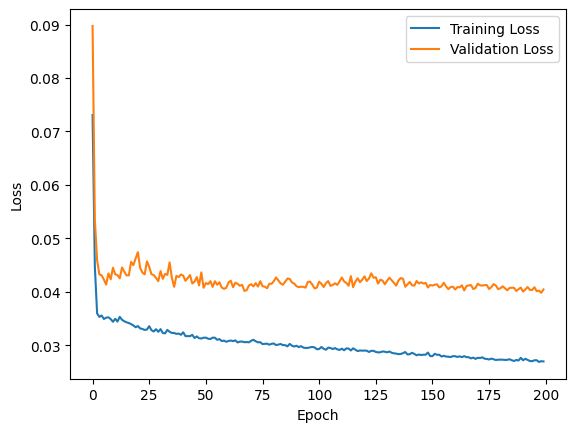

In [6]:
plt.clf()
plt.plot(best_train_loss, label="Training Loss")
plt.plot(best_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Predictions- and actual consumption

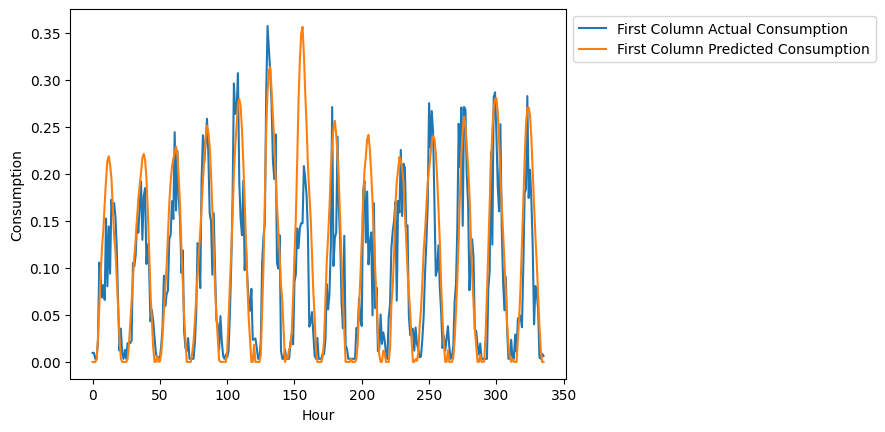

In [7]:
plot_predictions(110, 124, y_test, predicted)

Plot predictions for the first 7 days, last 7, and a week in the middle of the test set

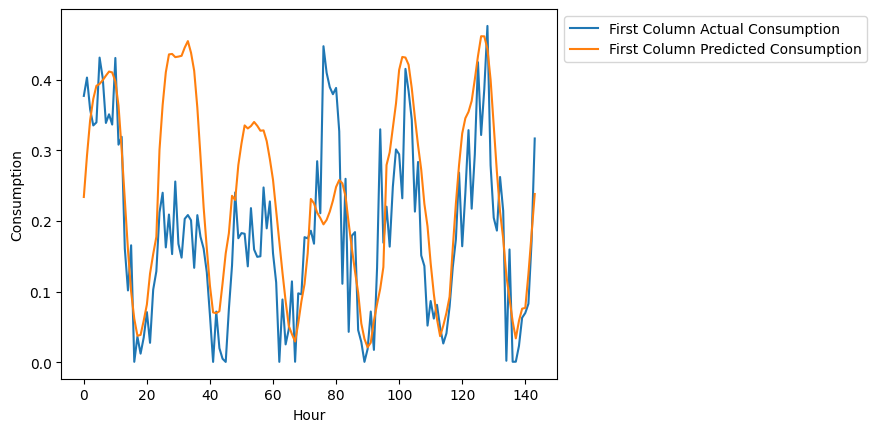

In [8]:
plot_predictions(0, 6, y_test, predicted)

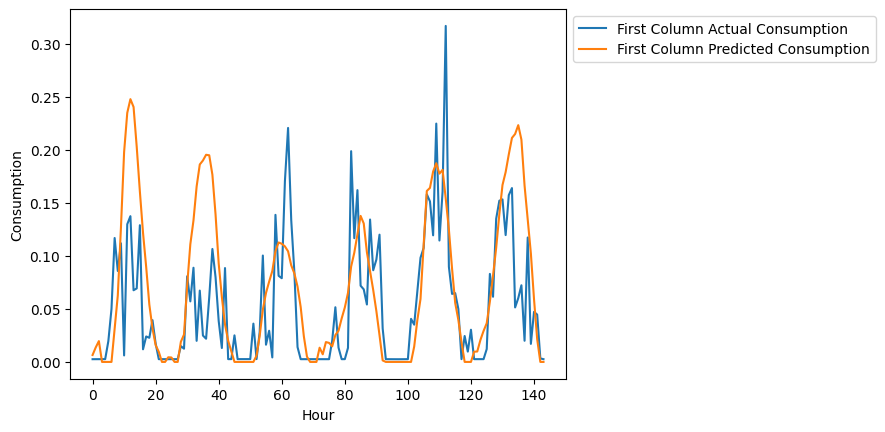

In [9]:
plot_predictions(-7, -1, y_test, predicted)

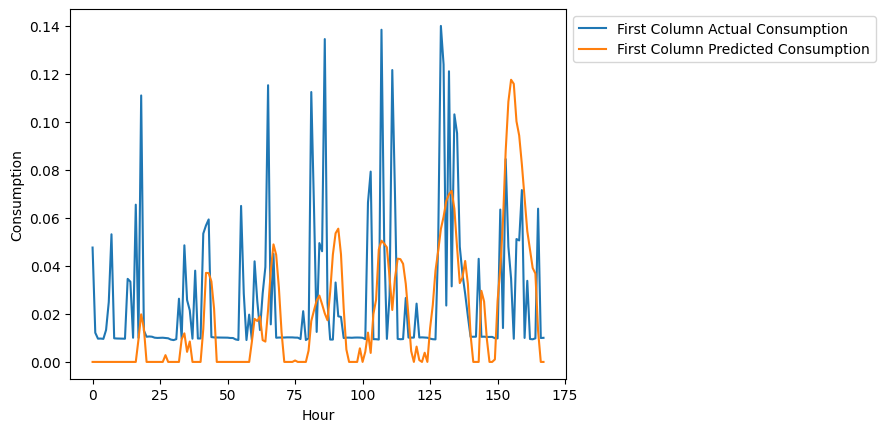

In [10]:
days_count = len(y_test) / 24
plot_predictions(int(days_count / 2), int(days_count / 2 + 7), y_test, predicted)